# 04 Jujukan bertempoh

Oleh: Murthadza bin Aznam <br>
Tarikh: 6th August 2021<br>

Nota interaktif ini ditulis sebagai sebahagian daripada kursus _International Virtual Conference on Astrostatistics and Machine Learning_ (IVCASML2021).

---

## 0.0 MATLAMAT
Matlamat nota ini ialah untuk menentukan tempoh satu kala bintang berdasarkan data dan kekangan tersebut:
1. Masa pencerapan
2. Magnitud cerapan yang diperoleh
3. Sela antara masa pencerapan tidak tetap

---

## 1 PERSIAPAN DATA

Kita gunakan Pandas untuk baca dail `JD_vs_B.data`.
- Indeks '0' ialah tarikh pencerapan dalam format Julian
- Index '1' ialah perbezaan magnitud, $\Delta B$
    - Perbezaan di sini merujuk kepada perbezaan yang dibandingkan dengan satu bintang rujukan.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Baca fail data menggunakan pandas
data = pd.read_fwf("../dataset/JD_vs_B.data", header=None)

Date = data[0].to_numpy() # Tarikh Julian
dB = data[1].to_numpy() # Perbezaan Magnitud

### 1.0 DATA: Plot Awal

Berikut ialah graf magnitud melawan tarikh

Text(0, 0.5, '$\\Delta B$')

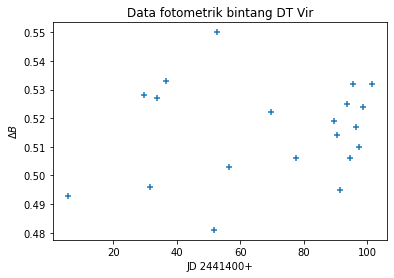

In [3]:
plt.scatter(Date, dB, marker="+")
plt.title("Data fotometrik bintang DT Vir")
plt.xlabel("JD 2441400+")
plt.ylabel(r"$\Delta B$")
#plt.xlim(0, 110)
#plt.ylim(0.48, 0.65)

### 1.1 DATA: Perbezaan antara magnitud min berbanding setiap data $\Delta B$
$$f = \Delta B - \overline{\Delta B}$$

In [4]:
dB_ = np.mean(dB)
f = dB - dB_

### 1.2 DATA: Frekuensi Nyquist

Kita gunakan frekuensi Nyquist untuk menentukan pemenggalan frekuensi dalam analisis kita.
$$N_f = \frac{1}{2\times (\Delta \text{Tarikh})_\text{minimum}}$$

In [5]:
# Perbezaan tarikh
dDate = np.diff(Date)

# Frekuensi Nyquist = 1/(2 kali perbezaan minimum)
N_f = 1/(2*min(dDate))

## 2 Penjelmaan Fourier Diskret Yang Mengambil Kira Tarikh (DCDFT: _Date Compensated Discrete Fourier Transform_)

### 2.1 DCDFT: Pekali Kehubungkaitan Spektrum

Pekali kehubungkaitan spektra untuk frekuensi tertentu ditentukan oleh:
$$S=\frac{c_{i}^{2}+c_{2}^{2}}{\sum_i f_{i}^{2}}$$

DENGAN MAKSUD:
$$\begin{aligned}
&c_{1}=a_{1} \sum f_{i} \cos x_{i} \\
&c_{2}=a_{2} \sum f_{i} \sin x_{i}-a_{1} a_{2} c_{1} M\\
&f_i = \text{Perbezaan antara magnitud min dengan magnitud}\\
\end{aligned}$$
dan setiap pemalar ialah:
$$\begin{aligned}
&a_{0}^{-2}=N \\
&a_{1}^{-2}=\sum \cos ^{2} x_{i}-a_{0}^{2}\left(\sum \cos x_{i}\right)^{2} \\
&M=\sum \cos x_{i} \sin x_{i}-a_{0}^{2}\left(\sum \sin x_{i}\right)\left(\sum \cos x_{i}\right) \\
&a_{2}^{-2}=\sum \sin ^{2} x_{i}-a_{0}^{2}\left(\sum \sin x_{i}\right)^{2}-a_{1}^{2} M^{2} \\
\end{aligned}$$

In [6]:
def spectral_corr_coef(obs_array, f_array, freq):
    """Pekali kehubungkaitan spektrum
    """
    x_array = 2*np.pi*freq*Date
    N = len(x_array)
    cos = np.cos(x_array)
    sin = np.sin(x_array)
    
    #Pemalar pertama
    a_0 = 1/np.sqrt(N)
    
    #Pemalar kedua
    eqn_1 = np.sum(cos**2) - (a_0**2)*(np.sum(cos))**2
    a_1 = 1/np.sqrt(eqn_1)

    #Pemalar ketiga
    M = np.sum(cos*sin) - (a_0**2)*(np.sum(sin))*(np.sum(cos))
    
    #Pemalar keempat
    eqn_2 = np.sum(sin**2) - (a_0**2)*(np.sum(sin))**2 - (a_1**2)*M**2
    a_2 = 1/np.sqrt(eqn_2)
    
    # Nilai c_1 dan c_2
    c_1 = a_1*np.sum(f_array*cos)
    c_2 = a_2*np.sum(f_array*sin) - a_1*a_2*c_1*M
    
    S = (c_1**2 + c_2**2)/np.sum(f_array**2)
    return S

In [10]:
# Menyediakan array frekuensi dari 0.1 ke N_f
freq = np.linspace(0.1, N_f, num=500)
S = [spectral_corr_coef(dB, f, omega) for omega in freq]
S = np.asarray(S)

Text(0.5, 1.0, 'Pekali kehubungkaitan spektrum melawan frekuensi')

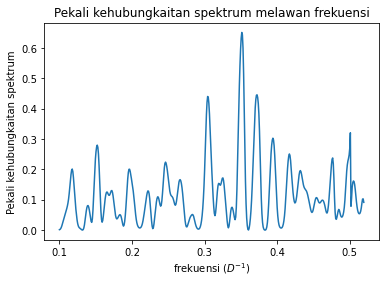

In [11]:
plt.plot(freq, S)
plt.xlabel(r"frekuensi ($D^{-1}$)")
plt.ylabel("Pekali kehubungkaitan spektrum")
plt.title("Pekali kehubungkaitan spektrum melawan frekuensi")

### 2.2 DCDFT: Keyakinan

Kita perlu hasilkan fungsi yang mengira keyakinan hasil kita:
$$\begin{aligned}
&G=-\frac{N-3}{2} \ln (1-S) \\
&H=\frac{N-4}{N-3}\left(G+e^{-G}-1\right) \\
&\alpha=\frac{2(N-3) \Delta t \cdot \Delta \omega}{3(N-4)} \\
&C=\left(1-e^{-H}\right)^{\alpha}
\end{aligned}$$

Kita takrifkan dua fungsi:
1. Parameter H
2. Keyakinan (C)

In [12]:
N = len(dB)

def H(S):
    """Parameter H
    """
    # Nilai G
    frac_g = -(N-3)/2
    ln = np.log(1-S)
    g = frac_g*ln
    
    frac = (N-4)/(N-3)
    bracket = g + np.exp(-g) - 1
    return frac*bracket

def C(S, Date, freq):
    """Fungsi Keyakinan
    """
    # Parameter alpha
    dT = max(Date) - min(Date)
    dFreq = max(freq) - min(freq)
    numerator = 2*(N-3)*dT*dFreq
    denom = 3*(N-4)
    alpha = numerator/denom
    
    return (1 - np.exp(-H(S)))**alpha

Text(0.5, 1.0, 'Parameter H vs frekuensi')

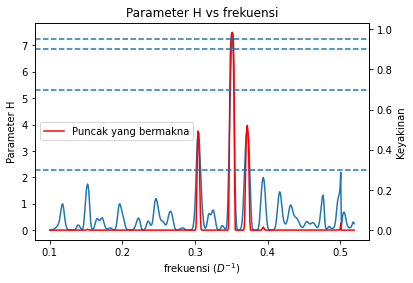

In [13]:
fig, ax = plt.subplots()
ax.plot(freq, H(S), label="Parameter H")
ax.set_ylabel("Parameter H")
ax2 = ax.twinx()
ax2.plot(freq, C(S, Date, freq), color="red", label="Puncak yang bermakna")
ax2.legend()
ax2.set_ylabel("Keyakinan")
ax2.axhline(y=0.3,ls='--')
ax2.axhline(y=0.7,ls='--')
ax2.axhline(y=0.9,ls='--')
ax2.axhline(y=0.95,ls='--')
ax.set_xlabel(r"frekuensi ($D^{-1}$)")
ax.set_title("Parameter H vs frekuensi")

### 2.3 DFDCT: Mencari nilai satu kala

Kita akan peroleh kalaan bintang dengan mencari frekuensi yang ada puncak tertinggi pada fungsi keyakinan:
$$P=\frac{1}{\omega_\text{puncak tertinggi}}$$

In [14]:
# Indeks puncak tertinggi
peak_idx = np.argmax(C(S, Date, freq))

# Frekuensi yang menghasilkan puncak tertinggi
peak = freq[peak_idx] 
P = 1/peak # Kalaan
print("Kalaan bintang ini ialah: ", P, " Hari")

Kalaan bintang ini ialah:  2.8474579284190398  Hari


### 2.4 DFDCT: Lengkung Cahaya

Sekarang ini kita sudah tahu kalaan bintang tersebut, sepatutnya kalau kita padankan magnitud dengan fasa masing-masing, kita akan dapat satu pola sinus.

In [15]:
Phase = (Date - Date[0])/P
Phase = np.mod(Phase, 1)

Text(0.5, 1.0, 'Lengkung cahaya bintang ini')

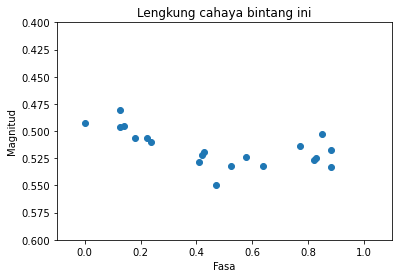

In [16]:
plt.scatter(Phase, dB)
plt.gca().invert_yaxis()
plt.ylim(0.6,0.4)
plt.xlim(-0.1,1.1)
plt.xlabel("Fasa")
plt.ylabel("Magnitud")
plt.title("Lengkung cahaya bintang ini")